In [1]:
from qiskit import QuantumCircuit, execute
from qiskit import IBMQ, Aer
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import NoiseModel

from qiskit import *
import numpy as np
from qiskit.visualization import plot_histogram
import qiskit.tools.jupyter
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.mitigation.measurement import *
import matplotlib.pyplot as plt

# below three lines were shifted up from block 2
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
import qiskit_aer.noise as noise

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

noise_model = noise.NoiseModel()

noise_model_TI = noise.NoiseModel() # initialize noise model for Trapped Ion Qubits
noise_model_S = noise.NoiseModel() # initialize noise model for Superconducting Qubits
noise_model_QD = noise.NoiseModel() # initialize noise model for Quantum Dot Qubits
noise_model_CC = noise.NoiseModel() # initialize noise model for Color Center Qubits


In [2]:
# Error probabilities: FOR TRAPPED ION QUBITS

prob_1 = 0.00001/100  # 1-qubit gate, 0.00001% error rate
prob_2 = 0.1/100   # 2-qubit gate, 0.1% error rate

# DEPOLARIZING QUANTUM ERRORS
error_1 = noise.depolarizing_error(prob_1, 1) # set depolarizing error for single-qubit gates
error_2 = noise.depolarizing_error(prob_2, 2) # set depolarizing error for double-qubit gates

# Add errors to noise model
noise_model_TI.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3', 'x'])
noise_model_TI.add_all_qubit_quantum_error(error_2, ['cx', 'cnot'])

# Need to add: 
# - Noise from:
#      - State Preparation and Measurement (SPAM) errors
#      - Dephasing errors? (maybe thermal decoherence will suffice?)
# - More graphs and stuff to compare?


In [3]:
# Error probabilities: FOR SUPERCONDUCTING QUBITS

prob_1 = 0.2/100  # 1-qubit gate, 0.2% error rate
prob_2 = 0.5/100   # 2-qubit gate, 0.5% error rate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1) # set depolarizing error for single-qubit gates
error_2 = noise.depolarizing_error(prob_2, 2) # set depolarizing error for double-qubit gates

# Add errors to noise model
noise_model_S.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3', 'x'])
noise_model_S.add_all_qubit_quantum_error(error_2, ['cx', 'cnot'])

# Need to add: 
# - Noise from:
#      - State Preparation and Measurement (SPAM) errors
#      - Dephasing errors? (maybe thermal decoherence will suffice?)
# - More graphs and stuff to compare?


In [4]:
# Error probabilities: FOR QUANTUM DOTS

prob_1 = 0.4/100  # 1-qubit gate, 0.4% error rate
prob_2 = 2/100   # 2-qubit gate, 2% error rate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1) # set depolarizing error for single-qubit gates
error_2 = noise.depolarizing_error(prob_2, 2) # set depolarizing error for double-qubit gates

# Add errors to noise model
noise_model_QD.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3', 'x'])
noise_model_QD.add_all_qubit_quantum_error(error_2, ['cx', 'cnot'])

# Need to add: 
# - Noise from:
#      - State Preparation and Measurement (SPAM) errors
#      - Dephasing errors? (maybe thermal decoherence will suffice?)
# - More graphs and stuff to compare?


In [5]:
# Error probabilities: FOR COLOR CENTERS

prob_1 = 0.0048/100  # 1-qubit gate, 0.0048% error rate
prob_2 = 0.8/100   # 2-qubit gate, 0.8% error rate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1) # set depolarizing error for single-qubit gates
error_2 = noise.depolarizing_error(prob_2, 2) # set depolarizing error for double-qubit gates

# Add errors to noise model
noise_model_CC.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3', 'x'])
noise_model_CC.add_all_qubit_quantum_error(error_2, ['cx', 'cnot'])

# Need to add: 
# - Noise from:
#      - State Preparation and Measurement (SPAM) errors
#      - Dephasing errors? (maybe thermal decoherence will suffice?)
# - More graphs and stuff to compare?


In [6]:
## THERMAL DECOHERENCE ERROR FOR TRAPPED ION QUBITS

# T1 and T2 values (decoherence times) for qubits in nanoseconds
T1s = 600000000 # It said around 10 minutes, so around 6*10^11 nS
T2s = 2*T1s  # Requirement: T2 <= 2T1

# Truncate random T2s <= T1s
# T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds) # PLACEHOLDER VALUES FOR GATE TIMES
                                        # (within 1000 to 100 000 nS)
time_u1 = 3000   # virtual gate
time_u2 = 3000  # (single X90 pulse)
time_u3 = 3000 # (two X90 pulses)
time_cx = 100000
time_reset = 3000  # 1 microsecond
time_measure = 3000 # 1 microsecond
time_x = 3000

# QuantumError objects
errors_reset = thermal_relaxation_error(T1s, T2s, time_reset)
                
errors_measure = thermal_relaxation_error(T1s, T2s, time_measure)

errors_u1  = thermal_relaxation_error(T1s, T2s, time_u1)

errors_u2  = thermal_relaxation_error(T1s, T2s, time_u2)

errors_u3  = thermal_relaxation_error(T1s, T2s, time_u3)

errors_cx = thermal_relaxation_error(T1s, T2s, time_cx).expand(
             thermal_relaxation_error(T1s, T2s, time_cx))

errors_x = thermal_relaxation_error(T1s, T2s, time_x)

# Add errors to noise model

noise_model_TI.add_all_qubit_quantum_error(errors_reset, "reset")
noise_model_TI.add_all_qubit_quantum_error(errors_measure, "measure")
noise_model_TI.add_all_qubit_quantum_error(errors_u1, "u1")
noise_model_TI.add_all_qubit_quantum_error(errors_u2, "u2")
noise_model_TI.add_all_qubit_quantum_error(errors_u3, "u3")

noise_model_TI.add_all_qubit_quantum_error(errors_x, "x")

noise_model_TI.add_all_qubit_quantum_error(errors_cx, "cx")

print(noise_model_TI)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3', 'x']
  Instructions with noise: ['reset', 'cnot', 'u3', 'x', 'cx', 'u1', 'u2', 'measure']
  All-qubits errors: ['u1', 'u2', 'u3', 'x', 'cx', 'cnot', 'reset', 'measure']


In [7]:
## THERMAL DECOHERENCE ERROR FOR SUPERCONDUCTING QUBITS

# T1 and T2 values (decoherence times) for qubits in nanoseconds
T1s = 50000 # It said around 10^-4 seconds (100 000 nS) to 10^-5 seconds (10 000 nS)
T2s = 2*T1s  # Requirement: T2 <= 2T1

# Truncate random T2s <= T1s
# T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds) # PLACEHOLDER VALUES FOR GATE TIMES
                                        # (within 10 to 100 nS)
time_u1 = 50  
time_u2 = 50  
time_u3 = 50  
time_cx = 50 
time_reset = 50   
time_measure = 50 
time_x = 50

# QuantumError objects
errors_reset = thermal_relaxation_error(T1s, T2s, time_reset)
                
errors_measure = thermal_relaxation_error(T1s, T2s, time_measure)

errors_u1  = thermal_relaxation_error(T1s, T2s, time_u1)

errors_u2  = thermal_relaxation_error(T1s, T2s, time_u2)

errors_u3  = thermal_relaxation_error(T1s, T2s, time_u3)

errors_cx = thermal_relaxation_error(T1s, T2s, time_cx).expand(
             thermal_relaxation_error(T1s, T2s, time_cx))

errors_x = thermal_relaxation_error(T1s, T2s, time_x)

# Add errors to noise model

noise_model_S.add_all_qubit_quantum_error(errors_reset, "reset")
noise_model_S.add_all_qubit_quantum_error(errors_measure, "measure")
noise_model_S.add_all_qubit_quantum_error(errors_u1, "u1")
noise_model_S.add_all_qubit_quantum_error(errors_u2, "u2")
noise_model_S.add_all_qubit_quantum_error(errors_u3, "u3")

noise_model_S.add_all_qubit_quantum_error(errors_x, "x")

noise_model_S.add_all_qubit_quantum_error(errors_cx, "cx")

print(noise_model_S)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3', 'x']
  Instructions with noise: ['reset', 'cnot', 'u3', 'x', 'cx', 'u1', 'u2', 'measure']
  All-qubits errors: ['u1', 'u2', 'u3', 'x', 'cx', 'cnot', 'reset', 'measure']


In [8]:
## THERMAL DECOHERENCE ERROR FOR QUANTUM DOT QUBITS

# T1 and T2 values (decoherence times) for qubits in nanoseconds
T1s = 150000 # It said around 10^-4 seconds (100 000 nS) to 10^-5 seconds (10 000 nS)
T2s = 300000  # Requirement: T2 <= 2T1

# Truncate random T2s <= T1s
# T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds) # PLACEHOLDER VALUES FOR GATE TIMES
                                        # (within 10 to 100 nS)
time_u1 = 100  
time_u2 = 100  
time_u3 = 100  
time_cx = 200 
time_reset = 100   
time_measure = 100 
time_x = 100

# QuantumError objects
errors_reset = thermal_relaxation_error(T1s, T2s, time_reset)
                
errors_measure = thermal_relaxation_error(T1s, T2s, time_measure)

errors_u1  = thermal_relaxation_error(T1s, T2s, time_u1)

errors_u2  = thermal_relaxation_error(T1s, T2s, time_u2)

errors_u3  = thermal_relaxation_error(T1s, T2s, time_u3)

errors_cx = thermal_relaxation_error(T1s, T2s, time_cx).expand(
             thermal_relaxation_error(T1s, T2s, time_cx))

errors_x = thermal_relaxation_error(T1s, T2s, time_x)

# Add errors to noise model

noise_model_QD.add_all_qubit_quantum_error(errors_reset, "reset")
noise_model_QD.add_all_qubit_quantum_error(errors_measure, "measure")
noise_model_QD.add_all_qubit_quantum_error(errors_u1, "u1")
noise_model_QD.add_all_qubit_quantum_error(errors_u2, "u2")
noise_model_QD.add_all_qubit_quantum_error(errors_u3, "u3")

noise_model_QD.add_all_qubit_quantum_error(errors_x, "x")

noise_model_QD.add_all_qubit_quantum_error(errors_cx, "cx")

print(noise_model_QD)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3', 'x']
  Instructions with noise: ['reset', 'cnot', 'u3', 'x', 'cx', 'u1', 'u2', 'measure']
  All-qubits errors: ['u1', 'u2', 'u3', 'x', 'cx', 'cnot', 'reset', 'measure']


In [9]:
## THERMAL DECOHERENCE ERROR FOR COLOR CENTER QUBITS

# T1 and T2 values (decoherence times) for qubits in nanoseconds
T1s = 187500 # It said around 10^-4 seconds (100 000 nS) to 10^-5 seconds (10 000 nS)
T2s = 375000  # Requirement: T2 <= 2T1

# Truncate random T2s <= T1s
# T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds) # PLACEHOLDER VALUES FOR GATE TIMES
                                        # (within 10 to 100 nS)
time_u1 = 50  
time_u2 = 50  
time_u3 = 50  
time_cx = 1000 
time_reset = 50   
time_measure = 50 
time_x = 50

# QuantumError objects
errors_reset = thermal_relaxation_error(T1s, T2s, time_reset)
                
errors_measure = thermal_relaxation_error(T1s, T2s, time_measure)

errors_u1  = thermal_relaxation_error(T1s, T2s, time_u1)

errors_u2  = thermal_relaxation_error(T1s, T2s, time_u2)

errors_u3  = thermal_relaxation_error(T1s, T2s, time_u3)

errors_cx = thermal_relaxation_error(T1s, T2s, time_cx).expand(
             thermal_relaxation_error(T1s, T2s, time_cx))

errors_x = thermal_relaxation_error(T1s, T2s, time_x)

# Add errors to noise model

noise_model_CC.add_all_qubit_quantum_error(errors_reset, "reset")
noise_model_CC.add_all_qubit_quantum_error(errors_measure, "measure")
noise_model_CC.add_all_qubit_quantum_error(errors_u1, "u1")
noise_model_CC.add_all_qubit_quantum_error(errors_u2, "u2")
noise_model_CC.add_all_qubit_quantum_error(errors_u3, "u3")

noise_model_CC.add_all_qubit_quantum_error(errors_x, "x")

noise_model_CC.add_all_qubit_quantum_error(errors_cx, "cx")

print(noise_model_CC)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3', 'x']
  Instructions with noise: ['reset', 'cnot', 'u3', 'x', 'cx', 'u1', 'u2', 'measure']
  All-qubits errors: ['u1', 'u2', 'u3', 'x', 'cx', 'cnot', 'reset', 'measure']


In [10]:
basis_gates = noise_model.basis_gates

In [11]:
basis_gates_TI = noise_model_TI.basis_gates

In [12]:
basis_gates_S = noise_model_S.basis_gates

In [13]:
basis_gates_QD = noise_model_QD.basis_gates

In [14]:
basis_gates_CC = noise_model_CC.basis_gates

In [15]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [16]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)    

In [17]:
## Start your code to create the circuit, qc4
qc4 = QuantumCircuit(6,5)
qc4.x(5)

for qubit in range(5):
    qc4.h(qubit)
repetitions = 1

for counting_qubit in range(5):
    for i in range(repetitions):
        qc4.cp(np.pi/7, counting_qubit, 5); # This is CU
    repetitions *= 2
    
qc4.barrier()

qft_dagger(qc4, 5)

qc4.barrier()

for n in range(5):
    qc4.measure(n,n)
    
    
qc4.draw()

┌───┐                                                               »
q_0: ┤ H ├─■─────────────────────────────────────────────────────────────»
     ├───┤ │                                                             »
q_1: ┤ H ├─┼────────■────────■───────────────────────────────────────────»
     ├───┤ │        │        │                                           »
q_2: ┤ H ├─┼────────┼────────┼────────■────────■────────■────────■───────»
     ├───┤ │        │        │        │        │        │        │       »
q_3: ┤ H ├─┼────────┼────────┼────────┼────────┼────────┼────────┼───────»
     ├───┤ │        │        │        │        │        │        │       »
q_4: ┤ H ├─┼────────┼────────┼────────┼────────┼────────┼────────┼───────»
     ├───┤ │P(π/7)  │P(π/7)  │P(π/7)  │P(π/7)  │P(π/7)  │P(π/7)  │P(π/7) »
q_5: ┤ X ├─■────────■────────■────────■────────■────────■────────■───────»
     └───┘                                                               »
c: 5/════════════════════════════════════════════════════════════════════»
                                                                         »
«                                                                             »
«q_0: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_1: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_2: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_3: ─■────────■────────■────────■────────■────────■────────■────────■───────»
«      │        │        │        │        │        │        │        │       »
«q_4: ─┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼───────»
«      │P(π/7)  │P(π/7)  │P(π/7)  │P(π/7)  │P(π/7)  │P(π/7)  │P(π/7)  │P(π/7) »
«q_5: ─■────────■────────■────────■────────■────────■────────■────────■───────»
«                                                                             »
«c: 5/════════════════════════════════════════════════════════════════════════»
«                                                                             »
«                                                                             »
«q_0: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_1: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_2: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_3: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_4: ─■────────■────────■────────■────────■────────■────────■────────■───────»
«      │P(π/7)  │P(π/7)  │P(π/7)  │P(π/7)  │P(π/7)  │P(π/7)  │P(π/7)  │P(π/7) »
«q_5: ─■────────■────────■────────■────────■────────■────────■────────■───────»
«                                                                             »
«c: 5/════════════════════════════════════════════════════════════════════════»
«                                                                             »
«                                                                             »
«q_0: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_1: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_2: ────────────────────────────────────────────────────────────────────────»


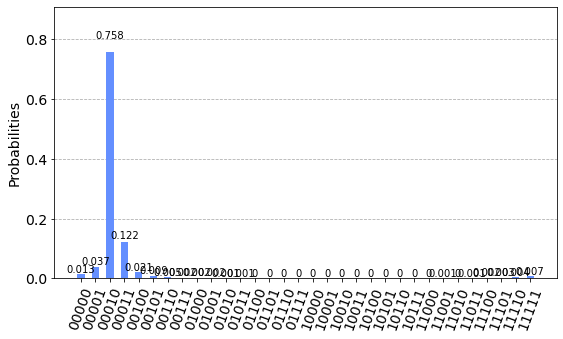

In [18]:
## Run this cell to simulate 'qc4' and to plot the histogram of the result
sim = Aer.get_backend('aer_simulator')
shots = 20000
count_qc4 = execute(qc4, sim, shots=shots).result().get_counts()
plot_histogram(count_qc4, figsize=(9,5))

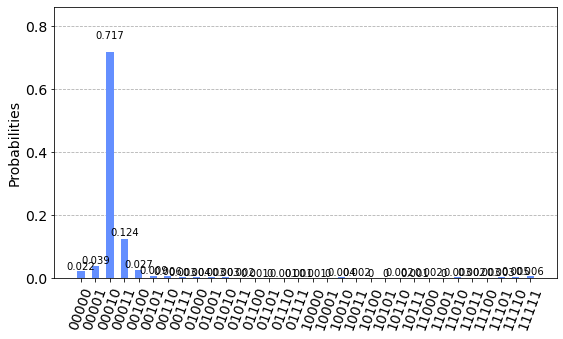

In [19]:
# Perform a noise simulation
sim = Aer.get_backend('aer_simulator')

shots = 20000
noise_model_TI_counts_qc4 = execute(qc4, 
                    sim, 
                    shots=shots,
                    basis_gates=basis_gates_TI,
                    noise_model=noise_model_TI).result().get_counts(0)
plot_histogram(noise_model_TI_counts_qc4, figsize=(9,5))

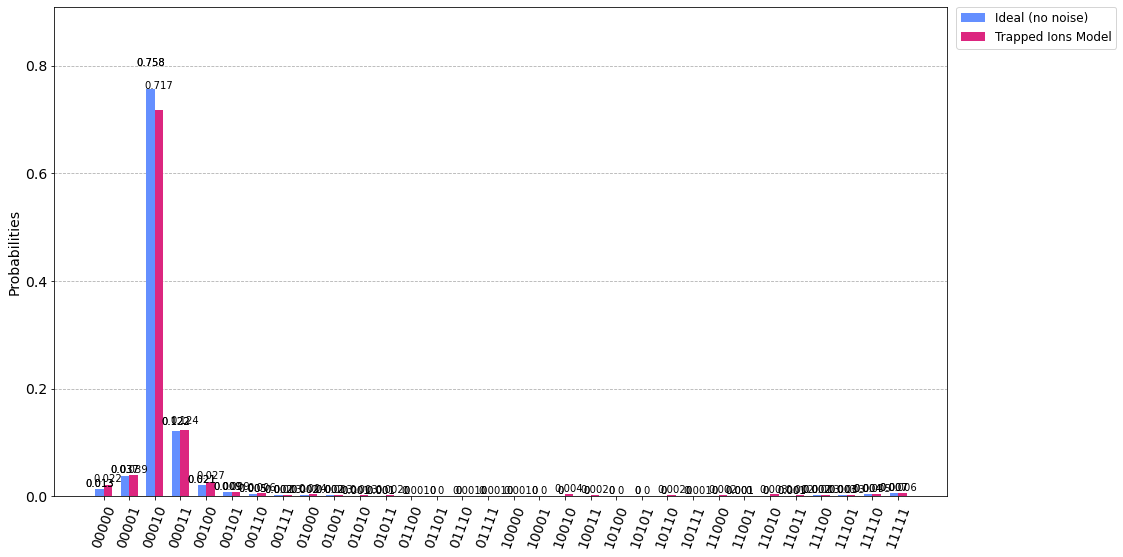

In [20]:
legend = ['Ideal (no noise)', 'Trapped Ions Model']

plot_histogram([count_qc4, noise_model_TI_counts_qc4], figsize=(16,9), legend = legend)

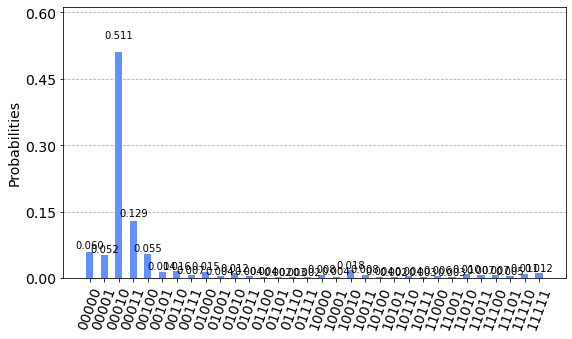

In [21]:
# Perform a noise simulation
sim = Aer.get_backend('aer_simulator') # defining the simulation backend

shots = 20000 # set number of shots

# below block gets the result of the circuit being run

noise_model_S_counts_qc4 = execute(qc4,                               # the name of the circuit to run (qc4 used here)
                    sim,                                              # sim is the backend to run it on (defined above)
                    shots=shots,                                      # shots is the number of runs
                    basis_gates=basis_gates_S,                        # basis_gates from the noise model needed
                    noise_model=noise_model_S).result().get_counts(0) # noise model goes here


plot_histogram(noise_model_S_counts_qc4, figsize=(9,5)) # plot histogram of counts

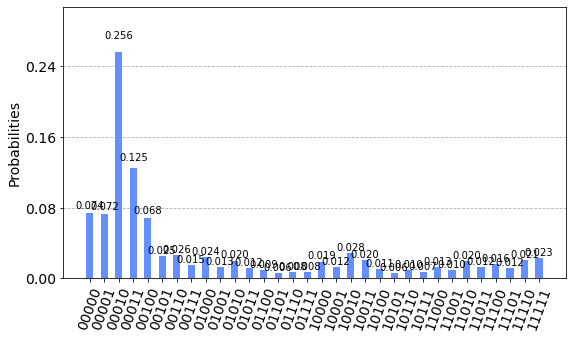

In [22]:
# Perform a noise simulation
sim = Aer.get_backend('aer_simulator')

shots = 20000
noise_model_QD_counts_qc4 = execute(qc4, 
                    sim, 
                    shots=shots,
                    basis_gates=basis_gates_QD,
                    noise_model=noise_model_QD).result().get_counts(0)
plot_histogram(noise_model_QD_counts_qc4, figsize=(9,5))

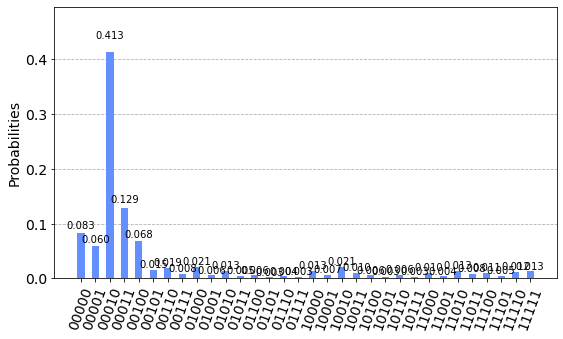

In [23]:
# Perform a noise simulation
sim = Aer.get_backend('aer_simulator')

shots = 20000
noise_model_CC_counts_qc4 = execute(qc4, 
                    sim, 
                    shots=shots,
                    basis_gates=basis_gates_CC,
                    noise_model=noise_model_CC).result().get_counts(0)
plot_histogram(noise_model_CC_counts_qc4, figsize=(9,5))

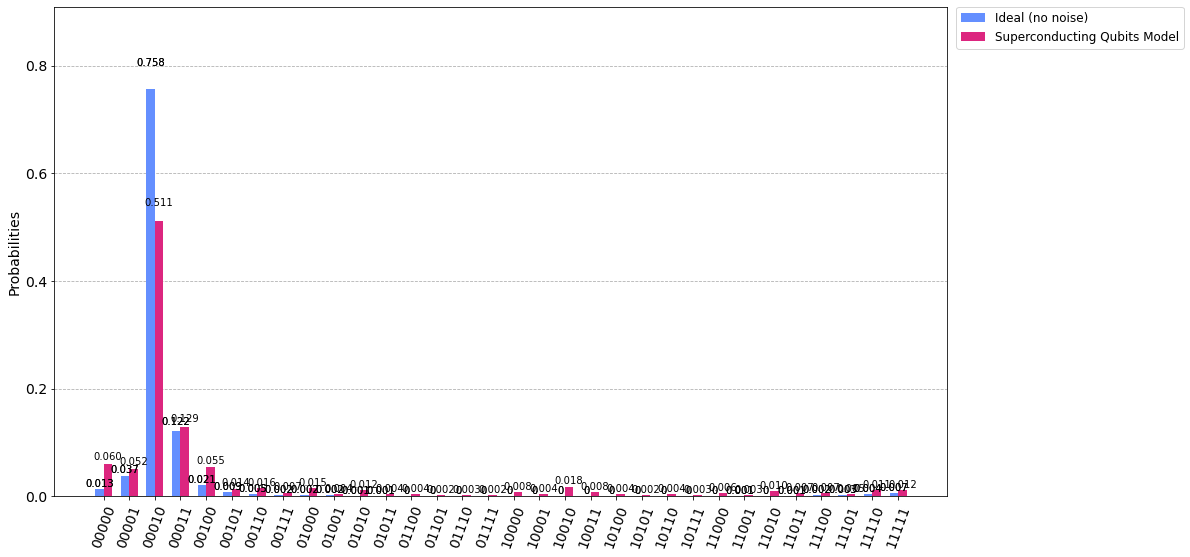

In [24]:
legend = ['Ideal (no noise)', 'Superconducting Qubits Model']

plot_histogram([count_qc4, noise_model_S_counts_qc4], figsize=(16,9), legend = legend)

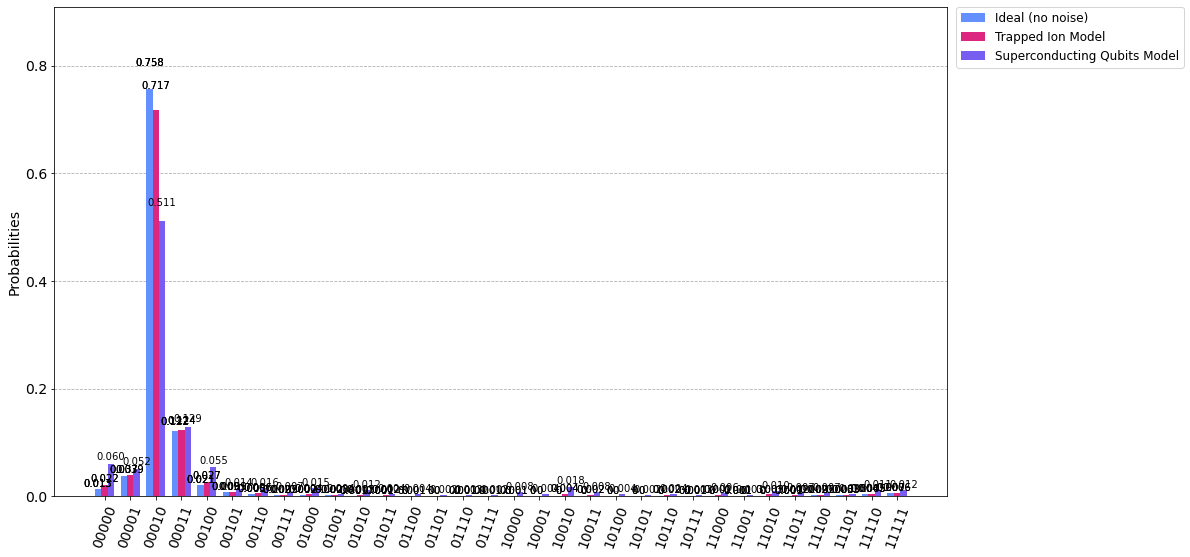

In [25]:
legend = ['Ideal (no noise)', 'Trapped Ion Model', 'Superconducting Qubits Model']
countsList = [count_qc4, noise_model_TI_counts_qc4, noise_model_S_counts_qc4]

plot_histogram(countsList, figsize=(16,9), legend = legend)

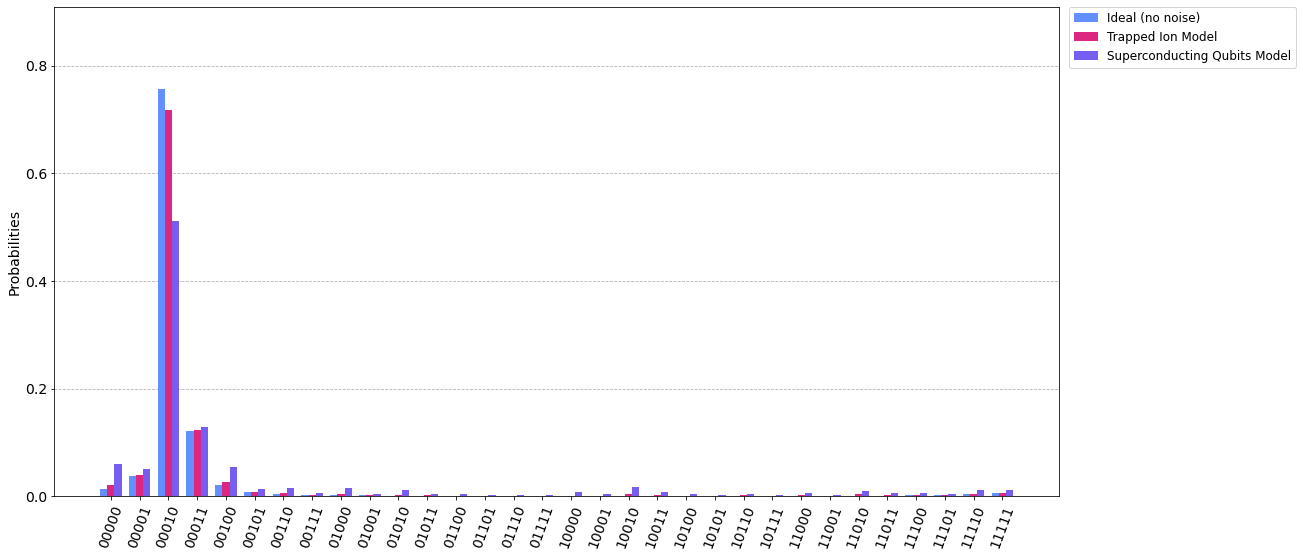

In [26]:
plot_histogram(countsList, figsize=(18,9), legend = legend, bar_labels = 0)

In [27]:
# Above is a representation of the Quantum-Phase-Estimation (QPE) circuit execution

# Blue - ideal circumstances (no noise)
# Pink - Execution with noise error aiming to emulate the performance of a Trapped Ion Quantum Computer
# Purple - Execution with noise error aiming to emulate the performance of a Superconducting Qubit Quantum Computer

# this model does include 2/3 of the main types of noise errors:
    # Depolarization Error (gate error) 
    # Thermal Decoherence Error (error due to limited amount of time to hold quantum state)
    
# note that this has no SPAM (state preparation and measurement) noise involved, could not find noise parameter values

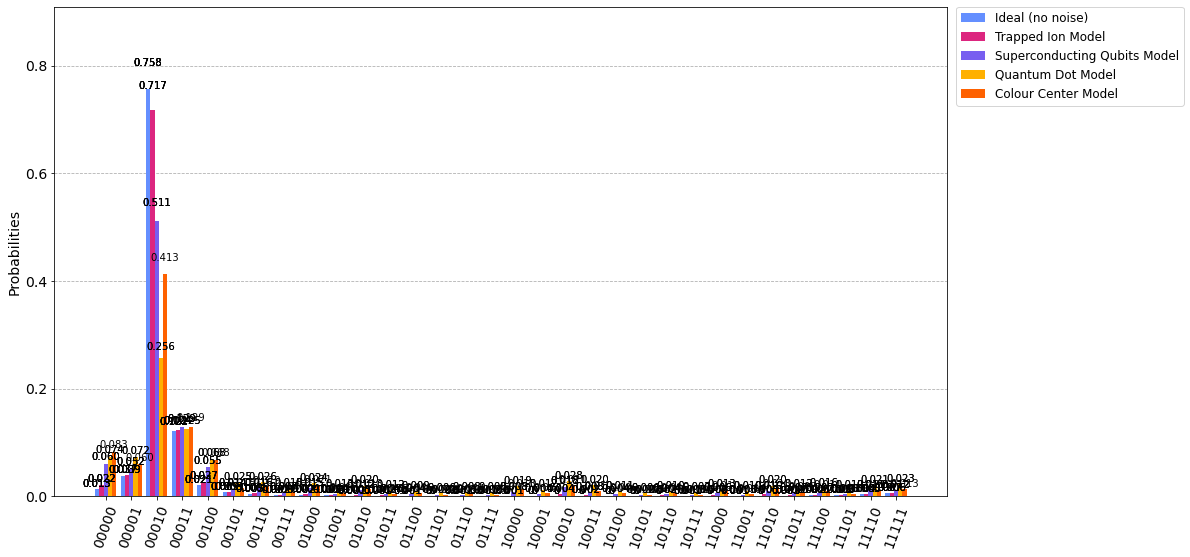

In [28]:
legend = ['Ideal (no noise)', 'Trapped Ion Model', 'Superconducting Qubits Model', 'Quantum Dot Model', 'Colour Center Model']
countsList = [count_qc4, noise_model_TI_counts_qc4, noise_model_S_counts_qc4, noise_model_QD_counts_qc4, noise_model_CC_counts_qc4]

plot_histogram(countsList, figsize=(16,9), legend = legend)

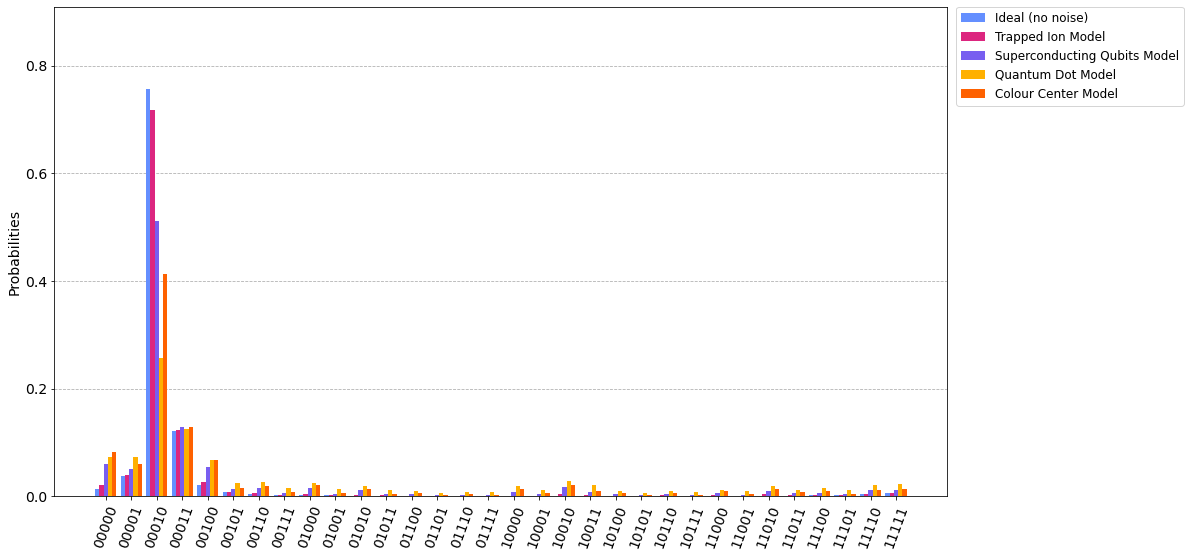

In [29]:
plot_histogram(countsList, figsize=(16,9), legend = legend, bar_labels = 0)